In [9]:
import os
import scipy
import os.path
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.linalg as la
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn
bidynrnn = tf.nn.bidirectional_dynamic_rnn

In [53]:
def process_data(vocab_size, min_len, max_len, len_saving_intervals, lim_unk):
    
    files = [os.path.join('./data/', dataset, f) for f in os.listdir(os.path.join('./data/', dataset)) 
             if f.endswith('.txt')]
    print('first pass (computing word frequencies)')
    start = time.clock()
    sent_counter = 0
    word_counts = Counter()
    
    for filename in files:
        with open(filename, 'r') as f:
            for line in f:
                sent_counter += 1
                if (sent_counter % 1000000 == 0) and (sent_counter > 0):
                    print("Read %dM sentences" % (sent_counter / 1000000))
                word_counts.update(word_tokenize(line.lower()))
            print('file processed; time taken = ' + str(time.clock() - start) + ' seconds')
    print('word frequencies computed; time taken = ' + str(time.clock() - start) + ' seconds')
    
    del word_counts['-end.of.document']
    
    valid_vocab = list(dict(word_counts.most_common(vocab_size)).keys())
    
    if lim_unk != 0.0:
        unk_token = '<UNK>'
        valid_vocab.append(unk_token)
    eos_token = '<EOS>'
    valid_vocab.append(eos_token)
    valid_vocab_index = {valid_vocab[i]: i for i in range(len(valid_vocab))}
    out_dir = './data/' + dataset + str(vocab_size) + '_' + str(min_len) + 'to' + str(max_len)
    
    if lim_unk is not None or lim_unk != 0.0:
        out_dir += '_limunk' + str(lim_unk)

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    with open(os.path.join(out_dir, 'valid_vocab.txt'), 'w') as out:
        d = json.dumps(valid_vocab)
        out.write(d)

    print('second pass (tokenizing sentences)')

    start = time.clock()
    num_sentences_processed = 0
    sentences = []

    for filename in files:
        with open(filename, 'r') as f:
            for sentence in f:
                valid_sentence = True
                sentence = sentence.strip().lower()
                sentence_tokens = word_tokenize(sentence)

                if len(sentence_tokens) < min_len or len(sentence_tokens) > max_len:
                    valid_sentence = False
                    continue

                if sentence == '---END.OF.DOCUMENT---' or ' ' not in sentence:
                    valid_sentence = False
                    continue

                sentence_indexed = []

                for t in sentence_tokens:
                    try:
                        sentence_indexed.append(valid_vocab_index[t])
                    except KeyError:
                        if lim_unk == 0.0:
                            valid_sentence = False
                            break
                        else:
                            sentence_indexed.append(valid_vocab_index[unk_token])

                if (lim_unk is not None and lim_unk > 0.0 and sentence_indexed.count(valid_vocab_index[unk_token]) 
                        / len(sentence_indexed) >= lim_unk):
                    valid_sentence = False
                    continue

                sentence_indexed.append(valid_vocab_index[eos_token])

                if valid_sentence:
                    sentences.append(sentence_indexed)

                num_sentences_processed += 1

                if num_sentences_processed % 100000 == 0:
                    print(str(num_sentences_processed) + ' sentences processed; time taken = ' 
                          + str(time.clock() - start) + ' seconds')

    print('There are ' + str(len(sentences)) + ' sentences.')

    for lower in range(1, max_len, len_saving_intervals):
        upper = lower + len_saving_intervals - 1
        print('saving ' + str(lower) + ' to ' + str(upper))
        sentences_range = [s for s in sentences if lower <= len(s) <= upper]
        
        with open(os.path.join(out_dir, str(lower) + '-' + str(upper) + '.txt'), 'w') as index:
            d = json.dumps(sentences_range)
            index.write(d)
    
def load_data(train_prop, restrict_min_length, restrict_max_length, load_batch_size=5000000, **kwargs):
    
    files = []
    for f in os.listdir(folder):
        try:
            lower = int(f[:f.find('-')])
            upper = int(f[f.find('-')+1:f.find('.')])
        except:
            continue
        if lower > restrict_max_length or upper < restrict_min_length:
            continue
        else:
            files.append(f)
    c = Counter()
    words = []
    eos_ind = valid_vocab.index('<EOS>')
    for f in files:
        with open(os.path.join('./data/' + str(vocab_size) + '_' + str(min_len) + 'to' + str(max_len), f), 'r') as d:
            words_d = d.read()
            new_words = json.loads(words_d)
            words += new_words
            if 'most_common' in kwargs:
                for w in new_words:
                    c.update(w)
    L = np.array([len(s) for s in words])
    max_L = max(L)
    word_arrays = []

    for i in range(0, len(L), load_batch_size):
        L_i = L[i: i+load_batch_size]
        word_array = np.full((len(L_i), max_L), -1, dtype='int32')
        word_array[L_i.reshape((L_i.shape[0], 1)) > np.arange(max(L))] = np.concatenate(words[i: i+load_batch_size])
        word_arrays.append(word_array)
        del L_i, word_array
    words_to_return = np.concatenate(word_arrays)

    np.random.seed(1234)
    training_mask = np.random.rand(len(words_to_return)) < train_prop

    training_data = words_to_return[training_mask]
    testing_data = words_to_return[~training_mask]
    training_lengths = L[training_mask]
    testing_lengths = L[~training_mask]
    
    return training_data, testing_data, training_lengths, testing_lengths

In [ ]:
train_prop = 0.9
vocab_size = 20000
min_len = 4
max_len = 500
len_saving_intervals = 5
lim_unk = 0.0

try:
    training_data, testing_data, training_lengths, testing_lengths = load_data(train_prop, min_len, max_len)
else:
    process_data(vocab_size, min_len, max_len, len_saving_intervals, lim_unk):

In [57]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [58]:
class EmbeddingsLSTMCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, reuse=None):       
        super(EmbeddingsLSTMCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return self._event_size

    def call(self, inputs, state):
        _, (state_c, state_m) = self._cell(inputs, state)
        state = tf.concat([state_c, state_m], 1)
        embedded = tf.layers.dense(state, self._event_size)
        return embedded, (state_c, state_m)

In [63]:
class RobustTextVAE(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=300, n_samples=50, seq_length=70, batch_size=10, dim_z=100):
        self._data = data                                               # B x T x D
        self._B = batch_size                                            # B - batch size
        self._T = seq_length                                            # T - number of time steps
        self._V = vocab_size                                            # D - dimensionality of each time step
        self._E = embedding_size 
        self._H = n_hidden                                              # H - dimensionality of RNN hidden states
        self._Z = dim_z
        self._Sz = n_samples                                            # Sz - number of samples from the posterior
        
        self.initialise_variables                                       #
        
        self.q_z = self.make_posterior_z
        self.q_y = self.make_posterior_y
        self.p_y = self.make_transitional
        self.make_reconstruction
        self.compute_elbo
        self.optimise
        
        
    @define_scope
    def initialise_variables(self):
        # Initialises all variables and RNN cells
        self._W = tf.gen_variable(shape=(self._E, self._V), name='embeddings', 
                                  initialiser=random_normal_initializer(0., 0.1))
        self._cell = tfn.LSTMBlockCell(self._H)
        self._embedding_cell = EmbeddingsLSTMCell(self._cell, self._E)
        
        self._post_cell_z = tfn.LSTMBlockCell(self._H)
        self._post_cell_f = tfn.LSTMBlockCell(self._H)
        self._post_cell_b = tfn.LSTMBlockCell(self._H)
        self._layer_z = tf.layers.Dense(self._E)
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        
    @define_scope
    def make_posterior_z(self):
        _, h = dynrnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus)
        return tfd.MultivariateNormalDiag(means, stds)
    
    @define_scope
    def make_kl_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))
    
    @define_scope
    def make_posterior_y(self):
        (out_f, out_b), _ = bidynrnn(self._post_cell_f, self._post_cell_b, inputs=self._data, dtype=tf.float32)        
        hidden = tf.concat([out_f, out_b], 2)
        embeddings = tf.layers.dense(means, self._E)
        means = tf.matmul(embeddings, self._W, tf.nn.softmax)
        return means
    
    @define_scope
    def make_transitional(self):
        self._code_z = self.q_z.sample(self._Sz)
        self._code_y = self.q_y.sample(self._Sz)
        hidden = self._layer_z(tf.reshape(self._code_z, [-1, self._Z]))
        code_y = tf.reshape(self._code_y, [-1, self._T, self._E])
        inputs = tf.concat([hidden, code_y[:, :-1]], 1)
        embeddings, _ = dynrnn(self._embedding_cell, inputs=inputs)
        means = tf.matmul(embeddings, self._W, tf.nn.softmax)
        return means

    @define_scope
    def make_kl_y(self):
        return tf.reduce_sum(self.q_y * tf.log(self.q_y - self.p_y)) / self.Sz
    
    @define_scope
    def make_reconstruction(self):
        means = self.q_y
        tf.reduce_sum(self._data

    @define_scope
    def compute_elbo(self):
        kl_z = self.make_kl_z
        kl_y = self.make_kl_y
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z - kl_y
        return loss, kl_z, kl_y, reconstruction

    @define_scope
    def optimise(self):
        # Optimses the ELBO function
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
        return self._optimiser.apply_gradients(zip(gradients, variables))

In [ ]:
tf.reset_default_graph()
S = 50 
B = 10 
T = 20 
I = 10000
H = 500
Z = 100
w_lambda = 0.
model_name = model_name = 'H_{}_Z_{}_B_{}_T_{}'.format(H, Z, B, T)
path = './video_sequence_model_{}'.format(model_name)
train = True
plot = False
restore = False

os.makedirs(path, exist_ok=True)
os.makedirs(path + '/ckpt', exist_ok=True)
os.makedirs(path + '/training_curves', exist_ok=True)

x_ = tf.placeholder(tf.float32, [B, T, 900])
gen_model = RobustVideoARGenerator(x_, n_hidden=H, n_samples=S, seq_length=T, batch_size=B, dim_z=Z)

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])

if restore:
    try:
        saver.restore(sess, path + '/ckpt/modelling.ckpt')
        sess.run(tf.variables_initializer([v for v in tf.global_variables() if 'forward' in v.name]))
        
    except tf.errors.NotFoundError as e:
        print('No model to load!')
        sess.run(tf.global_variables_initializer())
    
    try:
        elbos = np.load(os.path.join(path + '/training_curves/elbos.npy')).tolist()
        llks = np.load(os.path.join(path + '/training_curves/llks.npy')).tolist()
        kls_z = np.load(os.path.join(path + '/training_curves/kls_z.npy')).tolist()
        kls_y = np.load(os.path.join(path + '/training_curves/kls_y.npy')).tolist()
        test_elbos = np.load(os.path.join(path + '/training_curves/test_elbos.npy')).tolist()
    
    except FileNotFoundError as e:
        print('No training curves to restore')
        
else:
    sess.run(tf.global_variables_initializer())
    
if train:
    elbos = []; kls_z = []; kls_y = []; llks = []; test_elbos = []
    
    try:
        for i in range(I):
            idx = np.random.randint(0, training_data.shape[0], B)
            batch = training_data[idx, :T]

            elbo, kl_z, kl_y, llk = sess.run(gen_model.compute_elbo, {x_: batch})
            elbos.append(elbo); kls_z.append(kl_z); kls_y.append(kl_y); llks.append(llk)

            if i % 100 == 0:
                test_idx = np.random.randint(0, testing_data.shape[0], B)
                test_batch = testing_data[test_idx, :T]
                test_elbo, _, _, _ = sess.run(gen_model.compute_elbo, {x_: test_batch})
                test_elbos.append(test_elbo)

            if i % 1000 == 0:
                print('Iteration:', i, 'ELBO:', elbo, 'KL (z):', kl_z, 'KL (y):', kl_y, 'Reconstruction:', llk, 
                      'Test ELBO:', test_elbo)
                saver.save(sess, path + '/ckpt/modelling.ckpt')
                np.save(os.path.join(path + '/training_curves/elbos.npy'), np.stack(elbos))
                np.save(os.path.join(path + '/training_curves/llks.npy'), np.stack(llks))
                np.save(os.path.join(path + '/training_curves/kls_z.npy'), np.stack(kls_z))
                np.save(os.path.join(path + '/training_curves/kls_y.npy'), np.stack(kls_y))
                np.save(os.path.join(path + '/training_curves/test_elbos.npy'), np.stack(test_elbos))
            
            sess.run(gen_model.optimise, {x_: batch})
    
    except KeyboardInterrupt as e:
        pass
            
    saver.save(sess, path + '/ckpt/modelling.ckpt')
    np.save(os.path.join(path + '/training_curves/elbos.npy'), np.stack(elbos))
    np.save(os.path.join(path + '/training_curves/llks.npy'), np.stack(llks))
    np.save(os.path.join(path + '/training_curves/kls_z.npy'), np.stack(kls_z))
    np.save(os.path.join(path + '/training_curves/kls_y.npy'), np.stack(kls_y))
    np.save(os.path.join(path + '/training_curves/test_elbos.npy'), np.stack(test_elbos))

Iteration: 0 ELBO: -174342.0 KL (z): 202.309 KL (y): 9512.85 Reconstruction: -164627.0 Test ELBO: -174195.0
Iteration: 1000 ELBO: -125373.0 KL (z): 49.7929 KL (y): 496.859 Reconstruction: -124826.0 Test ELBO: -125347.0
Iteration: 2000 ELBO: -124835.0 KL (z): 0.294964 KL (y): 35.9202 Reconstruction: -124798.0 Test ELBO: -124849.0


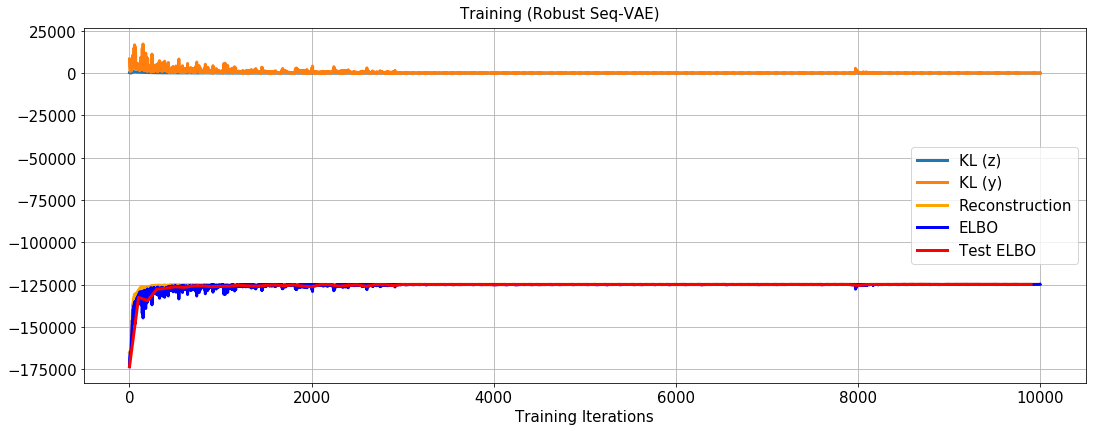

In [42]:
if True:
    fig, ax = plt.subplots(1, 1, figsize=(15,6))    
    plt.plot(kls_z, label='KL (z)', linewidth=3.0)
    plt.plot(kls_y, label='KL (y)', linewidth=3.0)
    plt.plot(llks, 'orange', label='Reconstruction', linewidth=3.0)
    plt.plot(elbos, 'b', label='ELBO', linewidth=3.0)
    plt.plot([100 * i for i in range(len(test_elbos))], test_elbos, 'r', label='Test ELBO', linewidth=3.0)
    ax.set_xlabel('Training Iterations', fontsize=15)
    plt.grid("on")
#     plt.ylim([-70000, 4000])
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    fig.suptitle('Training (Robust Seq-VAE)', fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15);
#     plt.savefig(path + '/training_curve.pdf', bbox_inches='tight')
    plt.show()

In [61]:
np.random.seed(0)
idx = np.random.randint(0, training_data.shape[0], B)
test_batch = training_data[idx, :T]
prior_means = sess.run(gen_model.p_y.mean(), {x_: test_batch})
post_means = sess.run(gen_model.q_y.mean(), {x_: test_batch})
latents = sess.run(gen_model._code_y, {x_: test_batch})

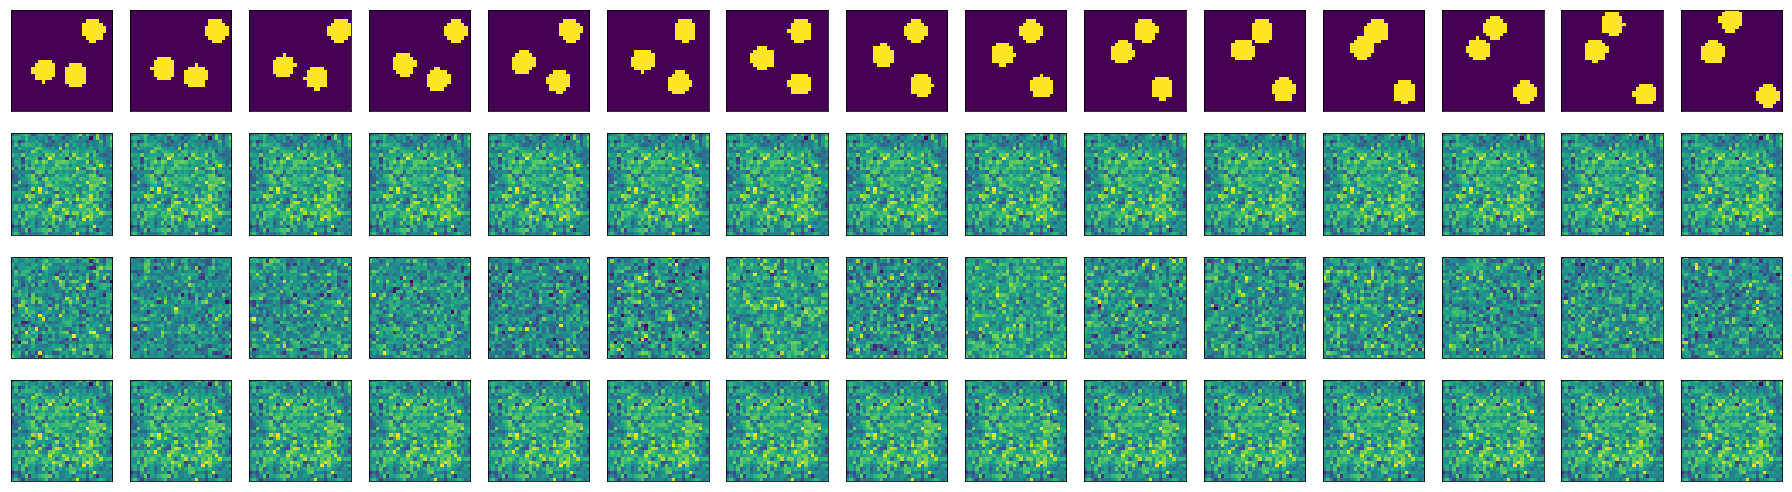

In [62]:
fig, axs = plt.subplots(nrows=4, ncols=15, figsize=(25, 7))
i = 0
for j in range(15):
    axs[0][j].imshow(np.reshape(test_batch[i], [-1, 30, 30])[j])
    axs[1][j].imshow(np.reshape(prior_means, [S, B, T, 30, 30])[0, i, j])
    axs[2][j].imshow(np.reshape(latents, [S, B, T, 30, 30])[0, i, j])
    axs[3][j].imshow(np.reshape(post_means, [B, T, 30, 30])[i, j])
for i in range(4):
    for j in range(15):
        axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
plt.tight_layout()
plt.show()